# Entrainment Test
Trying to figure out how much entrainment contributes to SLF in NorESM

In [60]:
from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

%matplotlib inline

Set up directories based on where the program is being run from

In [61]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    op_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(op_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

obs_dir = 'caliop_slfs/'
output_dir = 'figures/'
case_dir = 'mnth15runs/' # inconsistent label compared to jupy_test
    
# Check that each important directory can be accessed:    
access_paths = os.path.exists(obs_dir) and os.path.exists(output_dir) and os.path.exists(case_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [62]:
val_dir = 'NorESM_validation/'
os.path.exists(val_dir)

True

In [63]:
os.listdir(val_dir)

['20191209_143245_singleparam_hetrfrzoslo_elegant_inp10.cam.h0.0001-01.nc',
 '20191210_114516_singleparam_hetrfrzoslo_verbose_inp10',
 '20191205_151312_single_param_verbose_inp1.cam.h0.0001-01.nc',
 '20191219_151155_singleparam_cttest_wbf_1_inp_1.cam.h0.0001-01.nc',
 '20191209_171710_singleparam_hetrfrzoslo_dummies_inp10',
 'unused',
 '20200102_105235_singleparam_entraintest_1_1',
 '20191209_122334_singleparam_microandhetrfrz_usingpcols_inp10.cam.h0.0001-01.nc',
 '20191209_120756_singleparam_autohetrfrzoslo_inp10.cam.h0.0001-01.nc',
 '20191210_114516_singleparam_hetrfrzoslo_dummies_inp0.1',
 '20191206_124753_single_param_manualhetrfrzoslo_inp10.cam.h0.0001-01.nc']

In [64]:
basecase = '20191219_151155_singleparam_cttest_wbf_1_inp_1.cam.h0.0001-01.nc'
noentrain = '20200102_105235_singleparam_entraintest_1_1/atm/hist/20200102_105235_singleparam_entraintest_1_1.cam.h0.0001-01.nc'

<xarray.DataArray (isotherms_mpc: 9)>
array([ 8.57963031, 38.22314952, 43.8801838 , 57.7558221 , 63.35385045,
       73.81215322, 73.66798641, 88.91587212, 95.12674675])
Coordinates:
  * isotherms_mpc  (isotherms_mpc) float64 233.1 238.1 243.1 ... 268.1 273.1
<xarray.DataArray (isotherms_mpc: 9)>
array([ 9.64847678, 46.46163906, 55.56247336, 73.91211323, 77.45281716,
       87.29799999, 88.3877414 , 87.72313212, 92.13530703])
Coordinates:
  * isotherms_mpc  (isotherms_mpc) float64 233.1 238.1 243.1 ... 268.1 273.1


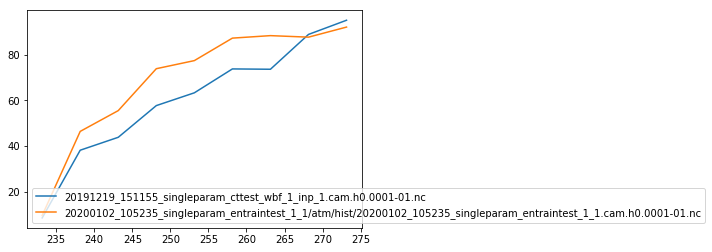

In [66]:
cases = [basecase,noentrain]
for case in cases:
    run = xr.open_dataset('%s%s' % (val_dir, case))
    run = add_weights(run)
    run['CT_SLF'] = run['CT_SLFXCLD_ISOTM']/run['CT_CLD_ISOTM']
    weights = run['cell_weight']
    slf = 100*masked_average(run['CT_SLF'], dim=['lat','lon','time'],weights=weights)
    plt.plot(slf['isotherms_mpc'], slf, label=case)
plt.legend()

Define latitude ranges of interest.

In [75]:
bands = {'Global':[-90,90],'Arctic':[66.667,90],'Antarctic':[-90,-66.667]}
df = pd.DataFrame()

In [94]:
#df['isotherm'] = slf1['isotherm']
#df = df.set_index('isotherm')
for i in bands:
    _rng = bands[i]
    
    # Different resolutions, needs different masks. Remember weird mask sign convention: true=not included
    mask1 = np.bitwise_or(ct_slf_caliop['lat']<_rng[0], ct_slf_caliop['lat']>_rng[1])
    mask2 = np.bitwise_or(ct_slf_noresm['lat']<_rng[0], ct_slf_noresm['lat']>_rng[1])
    
    weight1 = ct_slf_caliop['cell_weight']
    weight2 = ds['cell_weight'] #*ds['CT_CLD_ISOTM'] #Not sure about this
    
    slf2 = 100*masked_average(ct_slf_noresm, dim=['lat','lon','time'],weights=weight2, mask=mask2)
    
    stdev1 = 100*np.std(ct_slf_caliop['SLF'].sel(lat=slice(_rng[0],_rng[1])), axis=(0,1))
    stdev2 = 100*np.std(ct_slf_noresm.sel(lat=slice(_rng[0],_rng[1])), axis=(0,2,3))
    
    df['CALIOP %s SLF' % i] = slf1
    df['CALIOP %s StDev' % i] = stdev1
    df['NorESM %s SLF' % i] = slf2
    df['NorESM %s StDev' % i] = stdev2
df['isotherm'] = slf1['isotherm']
df

,CALIOP Global SLF,CALIOP Global StDev,NorESM Global SLF,NorESM Global StDev,CALIOP Arctic SLF,CALIOP Arctic StDev,NorESM Arctic SLF,NorESM Arctic StDev,CALIOP Antarctic SLF,CALIOP Antarctic StDev,NorESM Antarctic SLF,NorESM Antarctic StDev,isotherm
0,2.652094,5.807777,3.822959,17.586182,2.448328,2.686922,5.092532,16.641714,4.095303,4.009299,13.961278,30.321438,-40.0
1,16.110721,16.863898,23.234846,39.220856,11.182338,6.798517,34.588168,42.014248,29.083648,11.664116,60.165698,43.463421,-35.0
2,48.726922,26.783687,31.205616,42.484108,39.743815,11.886540,55.344561,45.543270,76.344829,9.706979,79.000091,34.763443,-30.0
3,68.557867,23.702292,44.925724,42.871029,66.755759,9.768171,74.332099,39.249313,84.836145,16.758521,88.480420,27.545029,-25.0
4,82.848191,18.481084,55.243124,40.328773,86.842881,6.023320,90.291369,21.637074,90.111826,17.041121,96.064839,12.643554,-20.0
5,89.782925,14.106420,68.141872,35.095181,94.521922,3.525254,96.001248,11.172071,94.810568,13.430821,98.942822,4.343795,-15.0
6,90.960496,13.894029,71.601288,33.459175,96.992953,3.093767,97.969091,7.101339,95.970086,13.618475,99.912542,1.338465,-10.0
7,91.791636,14.734814,88.768926,22.762476,97.131304,5.642598,99.823913,0.967777,96.772004,11.817037,99.938047,1.590085,-5.0
8,96.874805,9.863054,96.061309,13.541820,98.369610,5.955775,99.985028,0.128470,96.684488,15.223417,99.995633,0.008665,0.0
